In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from joblib import dump
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [2]:
plt.style.use('ggplot')

# 6-tree-models

In [3]:
X_train = pd.read_csv('../data/processed/train_features.csv')
y_train = pd.read_csv('../data/processed/train_target.csv')

In [4]:
X_test = pd.read_csv('../data/processed/test_features.csv')
y_test = pd.read_csv('../data/processed/test_target.csv')

In [5]:
X_train = X_train.select_dtypes('number')
X_test = X_test.select_dtypes('number')

In [6]:
cols = X_train.columns.tolist()

In [7]:
assert list(X_train.columns) == list(X_test.columns)

In [8]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

In [9]:
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [10]:
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

In [11]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

## Decision trees

In [12]:
tree = DecisionTreeRegressor(random_state=42)

In [13]:
param_grid = {
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 'auto'],
    'max_depth': list(range(1, 5))
}

In [14]:
t1 = time.time()
gscv = GridSearchCV(tree, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
39.7815682888031


In [15]:
tree = gscv.best_estimator_
tree

DecisionTreeRegressor(max_depth=4, max_features='auto', random_state=42)

In [16]:
dump(tree, '../models/decision_tree.joblib')

['../models/decision_tree.joblib']

In [17]:
y_pred = tree.predict(X_test)

In [18]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

7138.046200736673

In [19]:
tree_importance = pd.DataFrame(
    data=zip(cols, tree.feature_importances_.tolist()), 
    columns=['Feature', 'Importance']
)
tree_importance.sort_values('Importance', ascending=False, inplace=True)
tree_importance = tree_importance[tree_importance['Importance'] > 0]

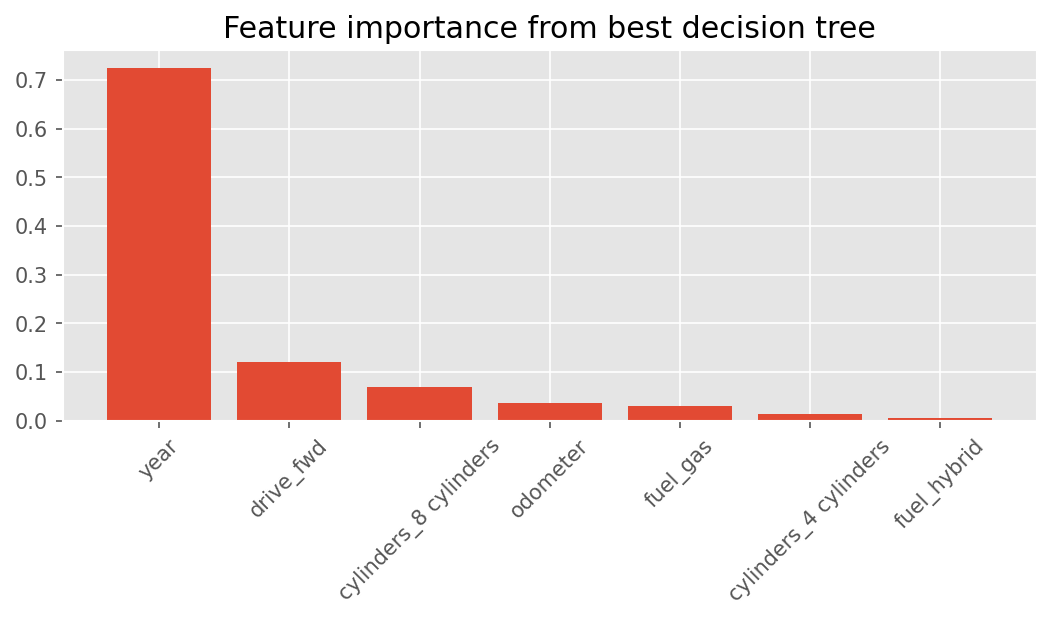

In [20]:
plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(tree_importance['Feature'], tree_importance['Importance'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Feature importance from best decision tree')
plt.savefig(f'../reports/figures/tree_importances.png')
plt.show()

## Random forests

In [21]:
forest = RandomForestRegressor(random_state=42)

In [22]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 4, 6, 8],    
    'n_estimators': [50, 100, 200, 400],
    'max_depth': list(range(1, 5))
}

In [23]:
t1 = time.time()
gscv = GridSearchCV(forest, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train.ravel())
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
8470.843999624252


In [24]:
forest = gscv.best_estimator_
forest

RandomForestRegressor(max_depth=4, n_estimators=200, random_state=42)

In [25]:
dump(forest, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [26]:
y_pred = forest.predict(X_test)

In [27]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(y_pred),
    squared=False
)

6954.627601810852

In [28]:
forest_importance = pd.DataFrame(
    data=zip(cols, forest.feature_importances_.tolist()), 
    columns=['Feature', 'Importance']
)
forest_importance.sort_values('Importance', ascending=False, inplace=True)
forest_importance = forest_importance[forest_importance['Importance'] > 0]

In [29]:
forest_importance

,Feature,Importance
1,year,0.723919
13,drive_fwd,0.126542
11,cylinders_8 cylinders,0.061311
0,odometer,0.038087
16,fuel_gas,0.032693
8,cylinders_4 cylinders,0.007455
10,cylinders_6 cylinders,0.004926
17,fuel_hybrid,0.004895
68,type_pickup,0.000173


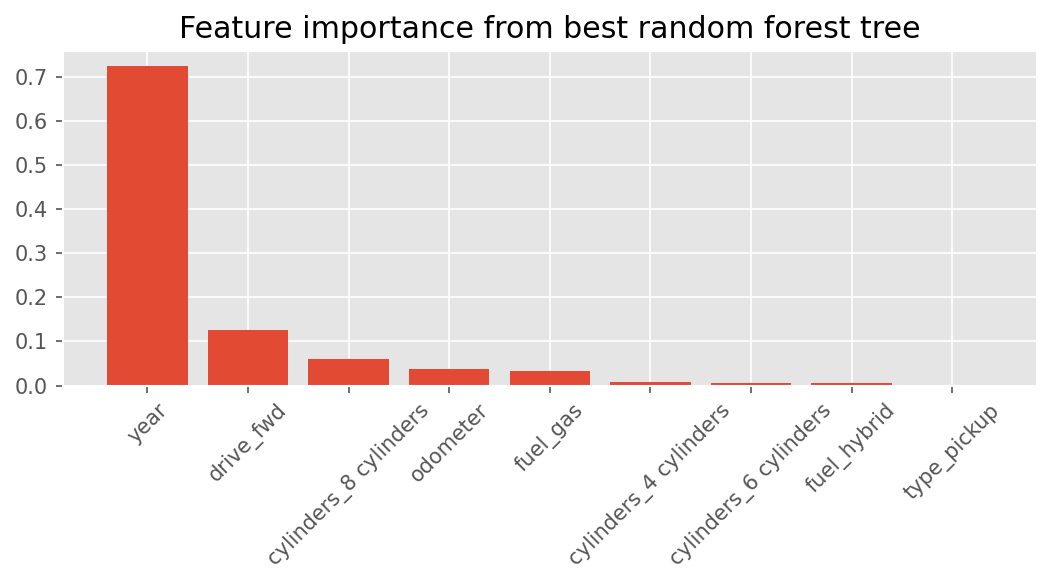

In [30]:
plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(forest_importance['Feature'], forest_importance['Importance'])
plt.xticks(rotation=45)
plt.title('Feature importance from best random forest tree')
plt.tight_layout()
plt.savefig(f'../reports/figures/forest_importances.png')
plt.show()

In [31]:
perm_importance = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = perm_importance['importances_mean']

In [32]:
perm_importance = pd.DataFrame(
    data=[perm_importance, cols],
    index=['Permutation importance', 'Feature']
).T

In [33]:
perm_importance = perm_importance[perm_importance['Permutation importance'] > 0]
perm_importance = perm_importance.sort_values('Permutation importance', ascending=False)

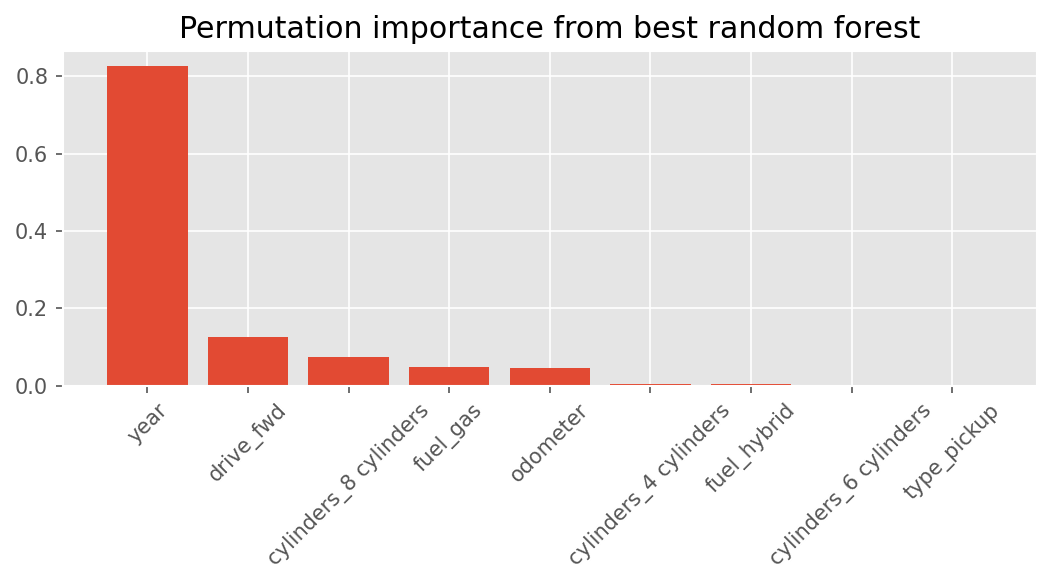

In [34]:
plt.figure(figsize=(4 * (16/9),4), dpi=150)
plt.bar(perm_importance['Feature'], perm_importance['Permutation importance'])
plt.xticks(rotation=45)
plt.title('Permutation importance from best random forest')
plt.tight_layout()
plt.savefig(f'../reports/figures/forest_permutation_importances.png')
plt.show()